## 1. Imports

In [1]:
from enum import Enum

import torch
from torch import nn, optim
import pandas as pd
import matplotlib.pyplot as plt

from torchero import SupervisedTrainer
from torchero.models.text import LinearModel
from torchero.utils.collate import BoWCollate
from torchero.utils.text import TextClassificationDataset, GLoVeVectors
from torchero.utils.data import train_test_split
from torchero.callbacks import ProgbarLogger
from torchero.hparams import OptimP
from torchero.meters import Precision, Recall, F1Score

In [2]:
USE_PRETRAINED_EMBEDDINGS = True
FREEZE_EMBEDDINGS = True

In [3]:
!head -n 1 /mnt/datasets/datasets/nlp/jigsaw-toxic-comment-classification-challenge/train.csv

"id","comment_text","toxic","severe_toxic","obscene","threat","insult","identity_hate"


In [4]:
if USE_PRETRAINED_EMBEDDINGS:
    vectors = GLoVeVectors.from_url()

## Load the dataset

In [5]:
df_train = pd.read_csv('/mnt/datasets/datasets/nlp/jigsaw-toxic-comment-classification-challenge/train.csv')

if USE_PRETRAINED_EMBEDDINGS:
    train_ds = TextClassificationDataset(df_train['comment_text'].tolist(),
                                         df_train["toxic"].tolist(),
                                         tokenizer='spacy:en',
                                         vocab=vectors.vocab)
else:
    train_ds = TextClassificationDataset(df_train['comment_text'].tolist(),
                                         df_train["toxic"].tolist(),
                                         tokenizer='spacy:en',
                                         vocab_max_size=100000)
train_ds, val_ds = train_test_split(train_ds, valid_size=0.2)
train_dl = train_ds.dataloader(collate_fn=BoWCollate(), batch_size=256, shuffle=True, num_workers=6)
val_dl = val_ds.dataloader(collate_fn=BoWCollate(), batch_size=256, shuffle=False, num_workers=6)

In [6]:
(x, l), y = next(iter(train_dl))
x, l, y

(tensor([   9, 5773,  198,  ..., 1076, 2491,    3]),
 tensor([    0,    50,    82,   111,   130,   199,   250,   440,   574,  1238,
          1327,  1332,  1383,  1455,  1542,  1604,  1613,  1785,  1806,  1923,
          1975,  1984,  1992,  2119,  2129,  2176,  2865,  2880,  2884,  2913,
          2924,  2978,  3593,  3642,  3691,  3813,  3819,  3892,  3929,  3935,
          4008,  4049,  4076,  4128,  4167,  4482,  4578,  4636,  4665,  4671,
          4739,  4781,  4903,  4953,  5005,  5534,  5750,  5759,  5801,  5846,
          6031,  6035,  6075,  6244,  6325,  6343,  6354,  6714,  6941,  6992,
          7198,  7213,  7235,  7389,  7455,  7479,  7482,  7789,  7809,  8026,
          8106,  8220,  8274,  8364,  8375,  8410,  8522,  8533,  8631,  8641,
          8685,  8695,  8727,  8762,  8795,  8855,  8871,  8972,  9009,  9015,
          9023,  9027,  9044,  9068,  9085,  9111,  9129,  9370,  9425,  9453,
          9459,  9532,  9600,  9635,  9741,  9855,  9885,  9901,  9956,  9962,

## Linear Model

In [7]:
len(train_ds.vocab)

400001

In [8]:
linear_model = LinearModel(len(train_ds.vocab),300)

In [9]:
if USE_PRETRAINED_EMBEDDINGS:
    linear_model.embeddings.weight.data[1:,:] = vectors.matrix
    linear_model.embeddings.weight.requires_grad = not FREEZE_EMBEDDINGS

In [10]:
linear_model_trainer = SupervisedTrainer(linear_model,
                                         criterion='binary_cross_entropy_wl',
                                         optimizer='adam',
                                         acc_meters=['binary_with_logits_accuracy',
                                                     Precision(with_logits=True),
                                                     Recall(with_logits=True),
                                                     F1Score(with_logits=True)],
                                       callbacks=[ProgbarLogger(notebook=True)])
linear_model_trainer.to('cuda')
linear_model_trainer.train(train_dl, val_dl, epochs=3)

  0%|          | 0/3 [00:00<?, ?epoch/s]

  0%|          | 0/624 [00:00<?, ? batchs/s]

  0%|          | 0/624 [00:00<?, ? batchs/s]

  0%|          | 0/624 [00:00<?, ? batchs/s]

### Training results

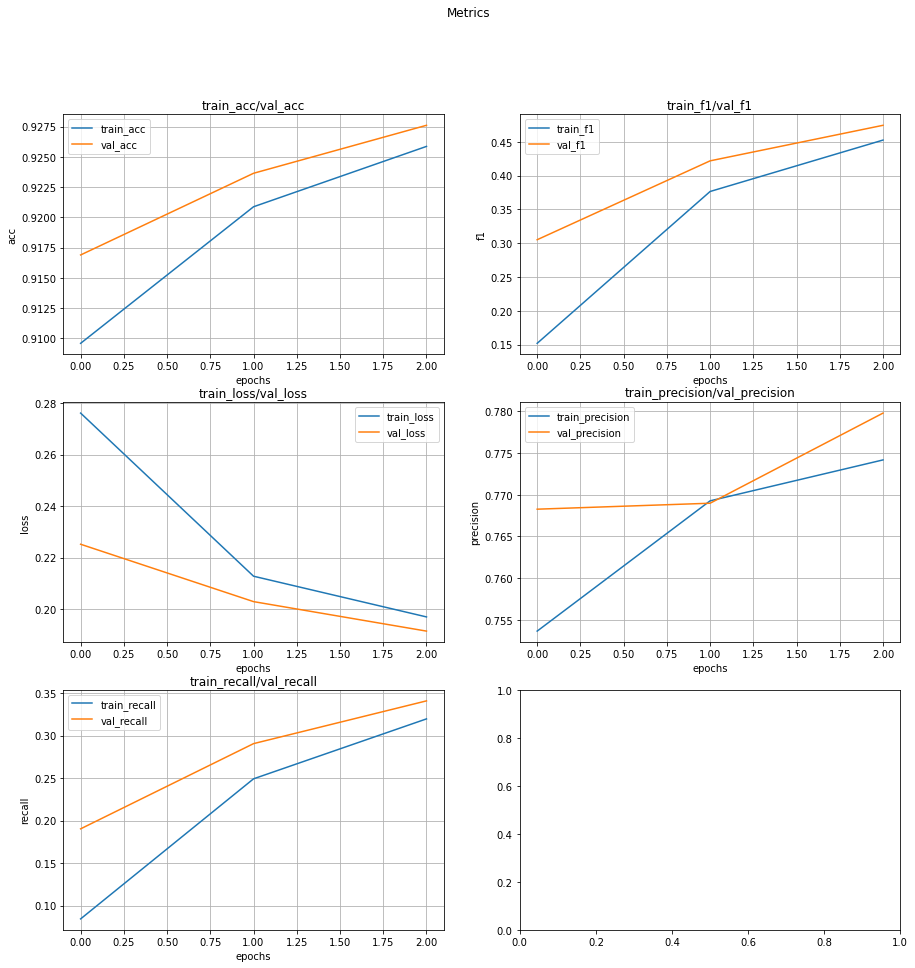

In [11]:
linear_model_trainer.history.plot()
plt.show()

In [15]:
class Conv1DBlock(nn.Module):
    def __init__(self, c_in, c_out, kernel_size=3, padding=(0, 0), stride=1, max_pool=True):
        super(Conv1DBlock, self).__init__()
        self.padding = nn.ConstantPad1d(padding, 0)
        self.conv = nn.Conv1d(c_in, c_out, kernel_size=kernel_size, stride=stride, padding=0)
        self.batch_norm = nn.BatchNorm1d(c_out)
        self.act = nn.ReLU(inplace=True)
        self.max_pool = nn.MaxPool1d(2) if max_pool else None
    
    def forward(self, x):
        x = self.act(self.batch_norm(self.conv(self.padding(x))))
        if self.max_pool is not None:
            x = self.max_pool(x)
        return x

class Conv1DSuperBlock(nn.Module):
    def __init__(self, c_in, c_out, kernel_sizes=[3], padding=[(0, 0)], stride=1, max_pool=True):
        super(Conv1DSuperBlock, self).__init__()
        assert(len(padding) == len(kernel_sizes))
        self.convs = [Conv1DBlock(c_in, c_out, kernel_size=k, padding=p, stride=stride, max_pool=max_pool)
                      for k, p in zip(kernel_sizes, padding)]
    
    def to(self, device):
        super(Conv1DSuperBlock, self).to(device)
        for conv in self.convs:
            conv.to(device)
        
    
    def forward(self, x):
        outputs = [conv(x) for conv in self.convs]
        return torch.cat(outputs, dim=1)
    

class ConvModel(nn.Module):
    def __init__(self, embedding_dim=50):
        super(ConvModel, self).__init__()
        self.embeddings = nn.Embedding(len(train_ds.vocab), embedding_dim=embedding_dim, padding_idx=train_ds.vocab[train_ds.vocab.pad])
        self.convs = nn.Sequential(Conv1DSuperBlock(embedding_dim, 32, [1,2,3], [(0, 0), (1, 0), (2, 0)]),
                                   Conv1DSuperBlock(32*3, 16, [1,2,3], [(0, 0), (1, 0), (2,0)]),
                                   Conv1DBlock(16*3, 20, 3, padding=(1,1), stride=1, max_pool=False),
                                   nn.AdaptiveMaxPool1d(1),
                                   nn.Flatten(),
                                   nn.Linear(20, 10),
                                   nn.ReLU(),
                                   nn.Dropout(0.5),
                                   nn.Linear(10, 1))
        
    def to(self, device):
        super(ConvModel, self).to(device)
        self.embeddings.to(device)
        self.convs[0].to(device)
        self.convs[1].to(device)
        self.convs[2].to(device)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = x.transpose(-1, 1)
        x = self.convs(x)
        return x.view(-1)

In [16]:
conv_model = ConvModel(100)

In [17]:
conv_trainer = SupervisedTrainer(conv_model,
                                 criterion='binary_cross_entropy_wl',
                                 optimizer='adam',
                                 acc_meters=['binary_with_logits_accuracy',
                                              Precision(with_logits=True),
                                              Recall(with_logits=True),
                                              F1Score(with_logits=True)],
                                 callbacks=[ProgbarLogger(notebook=True)])
conv_trainer.to('cuda')

train_dl = train_ds.dataloader(batch_size=256, shuffle=True, num_workers=6)
val_dl = val_ds.dataloader(batch_size=256, shuffle=False, num_workers=6)
conv_trainer.train(train_dl, val_dl, epochs=10)

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/624 [00:00<?, ? batchs/s]

  0%|          | 0/624 [00:00<?, ? batchs/s]

  0%|          | 0/624 [00:00<?, ? batchs/s]

  0%|          | 0/624 [00:00<?, ? batchs/s]

  0%|          | 0/624 [00:00<?, ? batchs/s]

  0%|          | 0/624 [00:00<?, ? batchs/s]

  0%|          | 0/624 [00:00<?, ? batchs/s]

  0%|          | 0/624 [00:00<?, ? batchs/s]

  0%|          | 0/624 [00:00<?, ? batchs/s]

  0%|          | 0/624 [00:00<?, ? batchs/s]

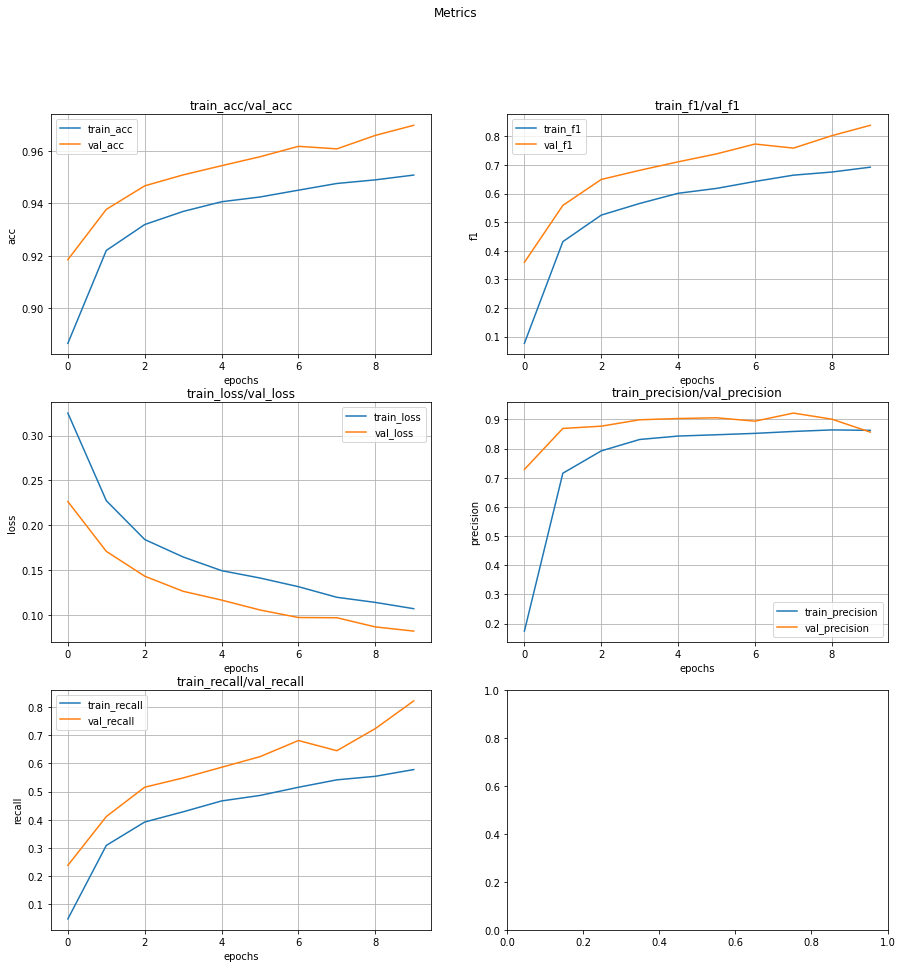

In [18]:
conv_trainer.history.plot()
plt.show()